In [2]:
# Import packages
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from spatialdata_io import visium
import os
import numpy as np
import anndata as ad
import igraph
import leidenalg

import json
from spatialdata import SpatialData
from spatialdata.models import Image2DModel
from spatialdata_io import visium
import spatialdata_plot

/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Load the data

In [3]:
# Set working directory
working_dir = os.getcwd()
data_path = working_dir


# Load the visium data (Healthy Mouse Liver_Mouse_001_Sample_001) into a spatial data object
sdata = visium(data_path, dataset_id = "GSM5764414_JBO001",counts_file = 'filtered_feature_bc_matrix.h5',tissue_positions_file = "tissue_positions_list.csv", scalefactors_file = "scalefactors_json.json",fullres_image_file=None)
adata = sdata.table
print(sdata)
adata.obs["total_counts"] = adata.X.sum(axis=1).A1 #The total number of counts of a certain gene.
adata.var["n_spots_by_counts"] = (adata.X > 0).sum(axis=0).A1 #The total number of spot that contains a certain gene.
adata.obs["n_genes_by_counts"] = (adata.X > 0).sum(axis=1).A1 #The total number of different genes that are expressed in a certain spot.

print(f'The original AnnData object contains: {adata.n_obs} spots and {adata.n_vars} genes. The original count is stored in AnnData.X')

# Load the annotation file of the mouse steady-state (StSt) Visium data (obtained from GSE192741)
annot = pd.read_csv('annot_mouseStStVisium.csv')

#select sample 'JBO1'
subset_annot = annot[annot['sample'] == 'JBO1'] 
subset_annot['spot'] = subset_annot['spot'].str[:-2]

INFO     reading /home/sarah/Documents/Design_project/MouseStStdata/filtered_feature_bc_matrix.h5                  


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/tmp/ipykernel_8490/3593914582.py:8: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = sdata.table


SpatialData object
├── Images
│     ├── 'GSM5764414_JBO001_hires_image': DataArray[cyx] (3, 2000, 1896)
│     └── 'GSM5764414_JBO001_lowres_image': DataArray[cyx] (3, 600, 569)
├── Shapes
│     └── 'GSM5764414_JBO001': GeoDataFrame shape: (1646, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (1646, 31053)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        GSM5764414_JBO001_hires_image (Images), GSM5764414_JBO001 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        GSM5764414_JBO001_lowres_image (Images), GSM5764414_JBO001 (Shapes)
    ▸ 'global', with elements:
        GSM5764414_JBO001 (Shapes)
The original AnnData object contains: 1646 spots and 31053 genes. The original count is stored in AnnData.X


/tmp/ipykernel_8490/3593914582.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_annot['spot'] = subset_annot['spot'].str[:-2]


/tmp/ipykernel_8490/2557185429.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata.table.obs['spot_ind'] = sdata.table.obs.index
/tmp/ipykernel_8490/2557185429.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.table.obs['spot_ind'] = sdata.table.obs.index
/tmp/ipykernel_8490/2557185429.py:3: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(sdata.table.obs.index)
/tmp/ipykernel_8490/2557185429.py:5: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  filtered_obs  = sdata.table.obs[sdata.table.obs['spot_ind'].isin(subset_annot['spot'])]
/tmp/ipykernel_8490/2557185429.py:6: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata_filtered = sdata.table[sdata.table.ob

Index(['AAACACCAATAACTGC-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1',
       'AAACCGGGTAGGTACC-1', 'AAACCGTTCGTCCAGG-1', 'AAACCTAAGCAGCCGG-1',
       'AAACGAGACGGTTGAT-1', 'AAACGGGCGTACGGGT-1', 'AAACTGCTGGCTCCAA-1',
       'AAAGGCTACGGACCAT-1',
       ...
       'TTGGTCACACTCGTAA-1', 'TTGGTTGCGGTGCGCG-1', 'TTGTAAGGACCTAAGT-1',
       'TTGTGAACCTAATCCG-1', 'TTGTGCAGCCACGTCA-1', 'TTGTGGTGGTACTAAG-1',
       'TTGTGTATGCCACCAA-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCATTAGTCTA-1',
       'TTGTTTCCATACAACT-1'],
      dtype='object', length=1293)
0       AAACACCAATAACTGC-1
1       AAACATTTCCCGGATT-1
2       AAACCCGAACGAAATC-1
3       AAACCGGGTAGGTACC-1
4       AAACCGTTCGTCCAGG-1
               ...        
1288    TTGTGGTGGTACTAAG-1
1289    TTGTGTATGCCACCAA-1
1290    TTGTTGTGTGTCAAGA-1
1291    TTGTTTCATTAGTCTA-1
1292    TTGTTTCCATACAACT-1
Name: spot, Length: 1293, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19886364..1.0].


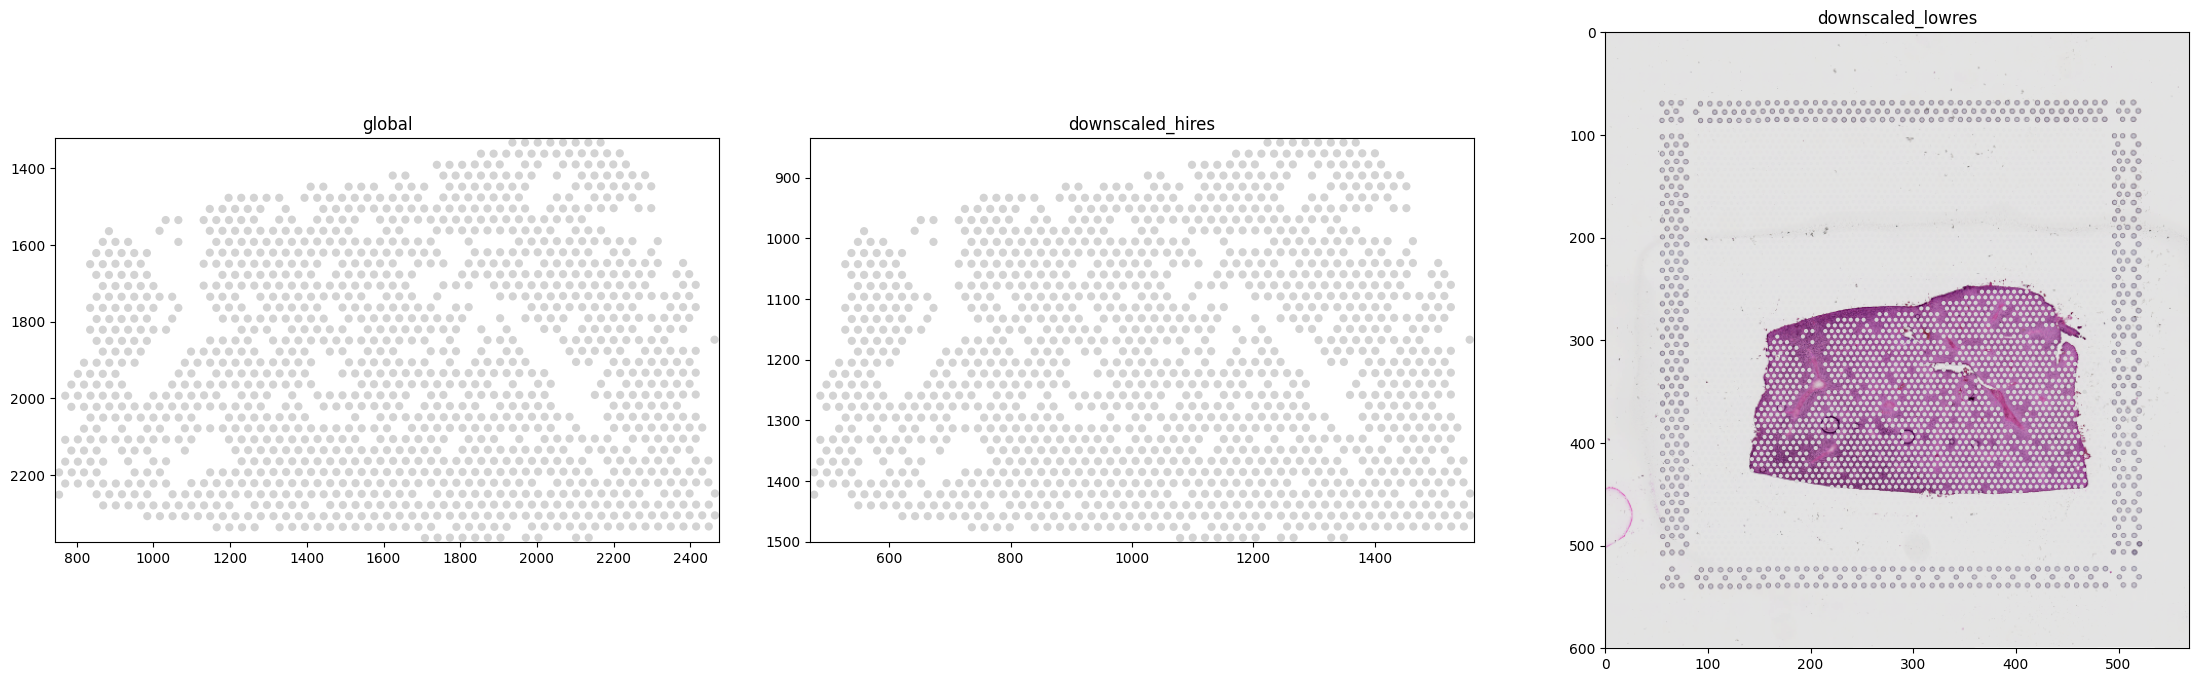

In [ ]:
# Only select spot_ids in the spatial data object that are present in the annotation file
sdata.table.obs['spot_ind'] = sdata.table.obs.index
filtered_obs  = sdata.table.obs[sdata.table.obs['spot_ind'].isin(subset_annot['spot'])]
sdata_filtered = sdata.table[sdata.table.obs['spot_ind'].isin(subset_annot['spot']), :]
del sdata.tables['table']
sdata.table = sdata_filtered

# Only keep spot_ids in the shapes present in the annotation file
sdata.shapes['GSM5764414_JBO001']['spot_id'] = sdata.shapes['GSM5764414_JBO001'].index
filtered_shapes = sdata.shapes['GSM5764414_JBO001'][sdata.shapes['GSM5764414_JBO001']['spot_id'].isin(sdata.table.obs['spot_id'])]
del sdata.shapes['GSM5764414_JBO001']
sdata.shapes['GSM5764414_JBO001'] = filtered_shapes

sdata.pl.render_images(elements="GSM5764414_JBO001_lowres_image").pl.render_shapes(elements="GSM5764414_JBO001").pl.show(figsize = (8,8))

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11290322..1.0].


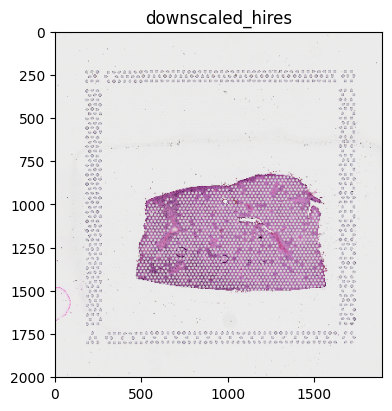

In [39]:
sdata.pl.render_images().pl.render_shapes().pl.show("downscaled_hires")

central: CentralVeinEndothelialcells
mid: 
portal: PortalVeinEndothelialcells
periportal: 

        Bcells  CentralVeinEndothelialcells  Cholangiocytes  Hepatocytes  \
0     0.000583                     0.000091        0.008327     0.944820   
1     0.000242                     0.006591        0.006088     0.944936   
2     0.000094                     0.000094        0.016154     0.945209   
3     0.000094                     0.000094        0.009134     0.955501   
4     0.000092                     0.000092        0.006378     0.931507   
...        ...                          ...             ...          ...   
1288  0.007462                     0.004891        0.006936     0.932385   
1289  0.001156                     0.003566        0.009227     0.940453   
1290  0.000093                     0.002540        0.009927     0.951132   
1291  0.000094                     0.003269        0.005953     0.941807   
1292  0.000393                     0.008223        0.004470     0.943868   

      Kupffercells     LSECs  Mesothelialcells  PortalVeinEndothelialcells  \
0        

/tmp/ipykernel_3663/2081294856.py:11: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  proportions.index = visium.table.obs.index
/tmp/ipykernel_3663/2081294856.py:12: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  subset_annot.index = visium.table.obs.index
/tmp/ipykernel_3663/2081294856.py:15: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  visium.table.obs['spatial_zonation'] = proportions['spatial_zonation']
/tmp/ipykernel_3663/2081294856.py:16: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  visium.table.obs['zonation_group'] = subset_annot['zonationGroup']
/tmp/ipykernel_3663/2081294856.py:17: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  visium.table.obs['Central

INFO     Rasterizing image for faster rendering.                                                                   


/tmp/ipykernel_3663/2081294856.py:22: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  visium.pl.render_images(elements="GSM5764414_JBO001_hires_image")\
/tmp/ipykernel_3663/2081294856.py:23: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  .pl.render_shapes(elements="GSM5764414_JBO001", color="n_genes_by_counts")\
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10526316..1.0].


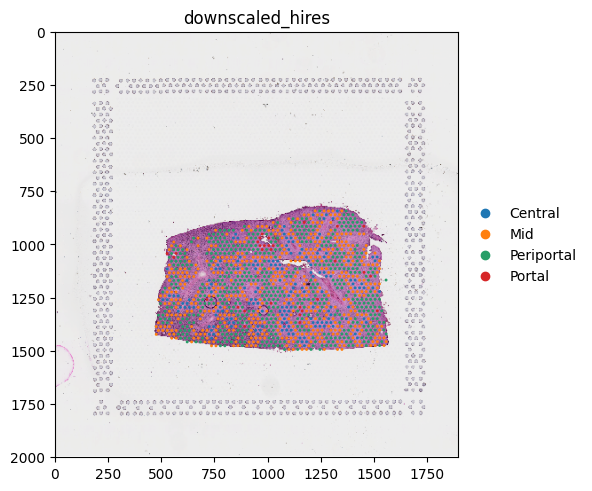

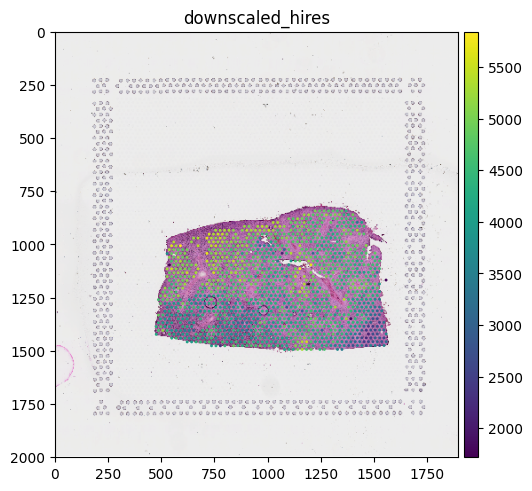

In [ ]:
# read csv data
proportions = pd.read_csv("ex_vivo_proportions_rctd_liver_mouseVisium_JB01.csv",delimiter = '\t')
columns_to_select = ["CentralVeinEndothelialcells", "PortalVeinEndothelialcells","LSECs"]
prop = proportions[columns_to_select]

# add column based on the spatial zonation
proportions["spatial_zonation"] = prop.idxmax(axis=1)

# Reindex proportions to match the index with the index of the visium.table.obs
proportions.index = sdata.table.obs.index
subset_annot.index = sdata.table.obs.index

# Add the spatial_zonation to the annData object
sdata.table.obs['spatial_zonation'] = proportions['spatial_zonation']
sdata.table.obs['zonation_group'] = subset_annot['zonationGroup']
sdata.table.obs['CentralVeinEndothelialcells'] = proportions['CentralVeinEndothelialcells']
sdata.table.obs['PortalVeinEndothelialcells'] = proportions['PortalVeinEndothelialcells']

# Render image
sdata.pl.render_images(elements="GSM5764414_JBO001_hires_image").pl.render_shapes(elements="GSM5764414_JBO001", color="zonation_group").pl.show("downscaled_hires")
sdata.pl.render_images(elements="GSM5764414_JBO001_hires_image")\
           .pl.render_shapes(elements="GSM5764414_JBO001", color="n_genes_by_counts")\
           .pl.show("downscaled_hires", save="n_genes_by_counts.png")

# QC and preprocessing

## QC

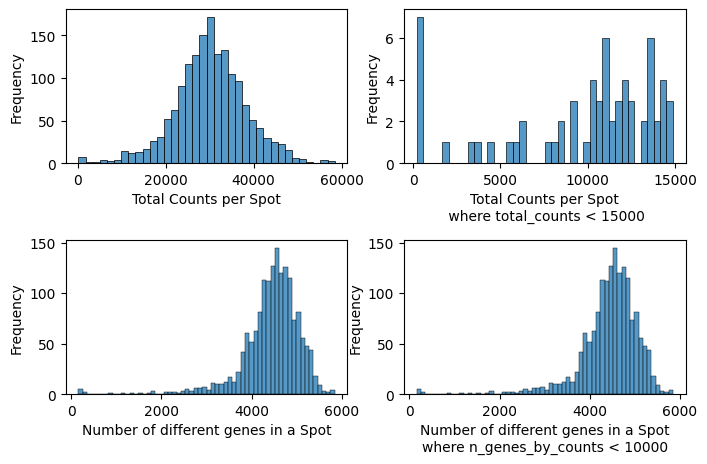

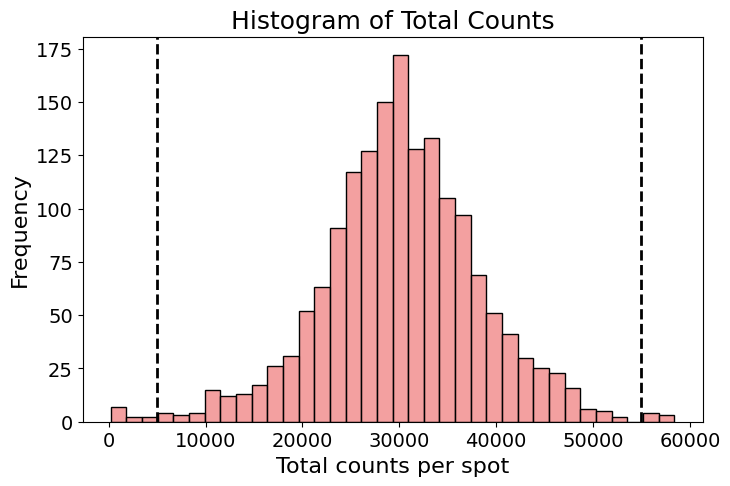

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8,5))

sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0,0])
axs[0,0].set_ylabel("Frequency")
axs[0,0].set_xlabel("Total Counts per Spot")
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 15000],
    kde=False,
    bins=40,
    ax=axs[0,1],
)
axs[0,1].set_xlabel("Total Counts per Spot\n where total_counts < 15000")
axs[0,1].set_ylabel("Frequency")

sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1,0])
axs[1,0].set_xlabel("Number of different genes in a Spot")
axs[1,0].set_ylabel("Frequency")
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 10000],
    kde=False,
    bins=60,
    ax=axs[1,1])
axs[1,1].set_xlabel("Number of different genes in a Spot\nwhere n_genes_by_counts < 10000")
axs[1,1].set_ylabel("Frequency")

plt.subplots_adjust(hspace=0.5)

fig, axs = plt.subplots(1, 1, figsize=(8,5))

sns.histplot(adata.obs["total_counts"], kde=False, ax=axs, color = 'lightcoral')

axs.set_ylabel("Frequency",fontsize=16)
axs.set_xlabel("Total counts per spot", fontsize=16)
axs.set_title("Histogram of Total Counts", fontsize=18) 
axs.tick_params(axis='both', labelsize=14)
axs.axvline(x=5000, color='black', linestyle='--', linewidth=2)
axs.axvline(x=55000, color = 'black',linestyle='--',linewidth=2)

## Preprocessing
Some spots have poor quality (e.g., damaged or stressed cells).

Expression of mitochondrial genes, total number of genes expressed, read distribution across genes and library size are good indicators for a spots quality.

A high-quality cell should have
- A high number of genes expressed
- A fair library size
- No major expression of mitochondrial genes, relative to other genes

number of spots after filtering: 1628
number of genes after filtering: 13531


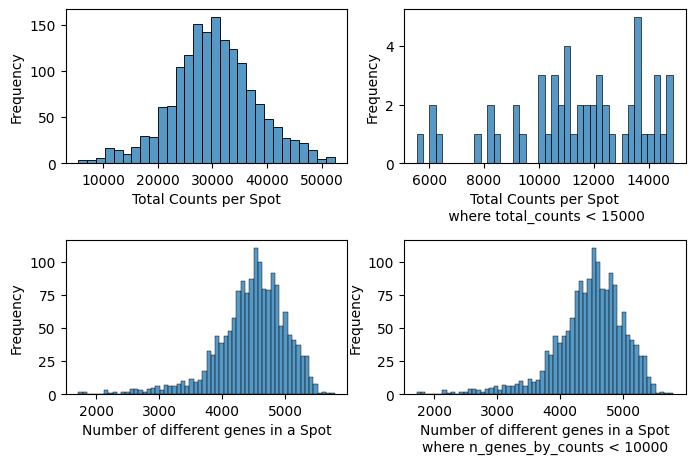

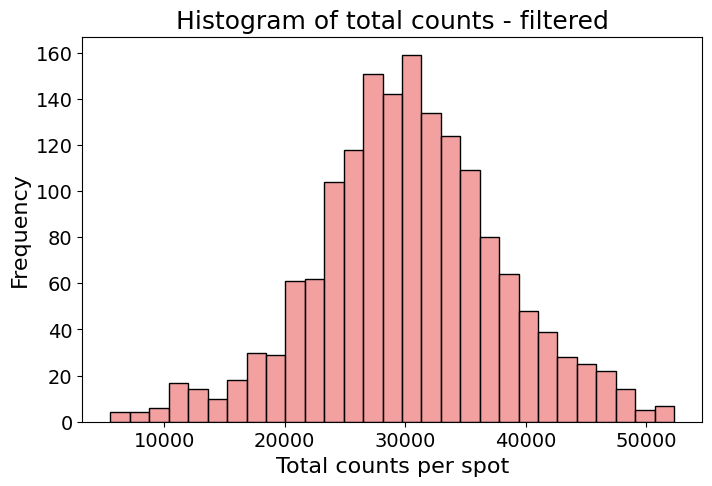

In [10]:
# Remove extremely high and low counts in one cell
sc.pp.filter_cells(adata, min_counts=5000) #e.g. empty droplets
sc.pp.filter_cells(adata, max_counts=55000) #e.g. multiple cells in one droplets

# Determine the percentage of mitochondrial genes per cell
mito_genes = adata.var_names[adata.var_names.str.startswith('mt')]
mito_counts = adata[:, mito_genes].X.sum(axis=1).A1
total_counts = adata.obs['total_counts'].values
adata.obs["mito_percentage"] = mito_counts/total_counts*100

# Remove cells with a high percentage of mitochondrial genes
adata = adata[adata.obs["mito_percentage"] < 20].copy()

# Filter non informative genes
sc.pp.filter_genes(adata, min_cells=10)

print(f"number of spots after filtering: {adata.n_obs}\nnumber of genes after filtering: {adata.n_vars}")

fig, axs = plt.subplots(2, 2, figsize=(8,5))

sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0,0])
axs[0,0].set_ylabel("Frequency")
axs[0,0].set_xlabel("Total Counts per Spot")
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 15000],
    kde=False,
    bins=40,
    ax=axs[0,1],
)
axs[0,1].set_xlabel("Total Counts per Spot\n where total_counts < 15000")
axs[0,1].set_ylabel("Frequency")

sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1,0])
axs[1,0].set_xlabel("Number of different genes in a Spot")
axs[1,0].set_ylabel("Frequency")
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 10000],
    kde=False,
    bins=60,
    ax=axs[1,1])
axs[1,1].set_xlabel("Number of different genes in a Spot\nwhere n_genes_by_counts < 10000")
axs[1,1].set_ylabel("Frequency")

plt.subplots_adjust(hspace=0.5)

fig, axs = plt.subplots(1, 1, figsize=(8,5))

sns.histplot(adata.obs["total_counts"], kde=False, ax=axs, color = 'lightcoral')
axs.set_ylabel("Frequency",fontsize=16)
axs.set_xlabel("Total counts per spot",fontsize=16)
axs.set_title("Histogram of total counts - filtered", fontsize=18) 
axs.tick_params(axis='both', labelsize=14)

### Normalisation

In [11]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Clustering

/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


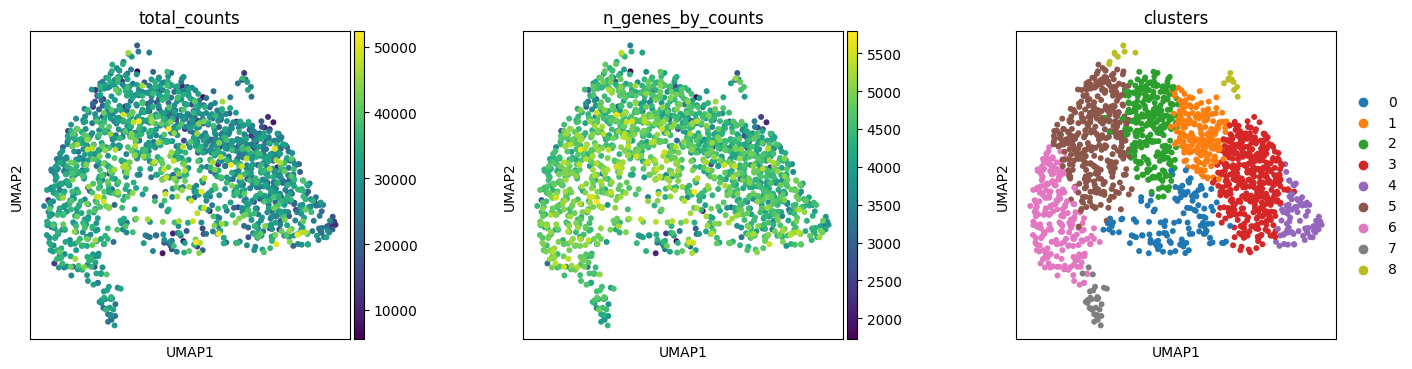

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

# Visualization in spatial coordinates

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11290322..1.0].


SpatialData object
├── Images
│     ├── 'GSM5764414_JBO001_hires_image': DataArray[cyx] (3, 2000, 1896)
│     └── 'GSM5764414_JBO001_lowres_image': DataArray[cyx] (3, 600, 569)
├── Shapes
│     └── 'GSM5764414_JBO001': GeoDataFrame shape: (1293, 3) (2D shapes)
└── Tables
      └── 'table': AnnData (1293, 31053)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        GSM5764414_JBO001_hires_image (Images), GSM5764414_JBO001 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        GSM5764414_JBO001_lowres_image (Images), GSM5764414_JBO001 (Shapes)
    ▸ 'global', with elements:
        GSM5764414_JBO001 (Shapes)


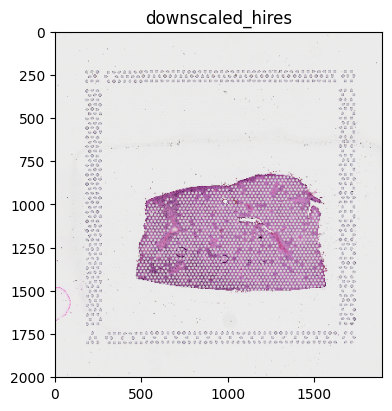

In [13]:
visium.pl.render_images().pl.render_shapes().pl.show("downscaled_hires")
print(visium)

In [14]:
visium["table"].to_df().sum(axis=0).sort_values(ascending=False).head(10)
#print(visium.table.obs["spot_id"])
data = visium.shapes
#print(data["GSM5764414_JBO001"])

print(visium.shapes['GSM5764414_JBO001']['geometry'])

IndexError: index (1645) out of range

## Deconvolution proportions

len(proportions["spatial_zonation"]): 1293
len(visium.table.obs): 1646
len(visium.shapes[GSM5764414_JBO001]): 1646


/tmp/ipykernel_4919/3194627703.py:10: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print('len(visium.table.obs):',len(visium.table.obs))
/tmp/ipykernel_4919/3194627703.py:22: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  visium.table.obs["spatial_zonation"] = proportions["spatial_zonation"]
/tmp/ipykernel_4919/3194627703.py:26: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  visium.pl.render_images(elements="GSM5764414_JBO001_hires_image").pl.render_shapes(elements="GSM5764414_JBO001", color="spatial_zonation").pl.show()
/tmp/ipykernel_4919/3194627703.py:26: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `elemen

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

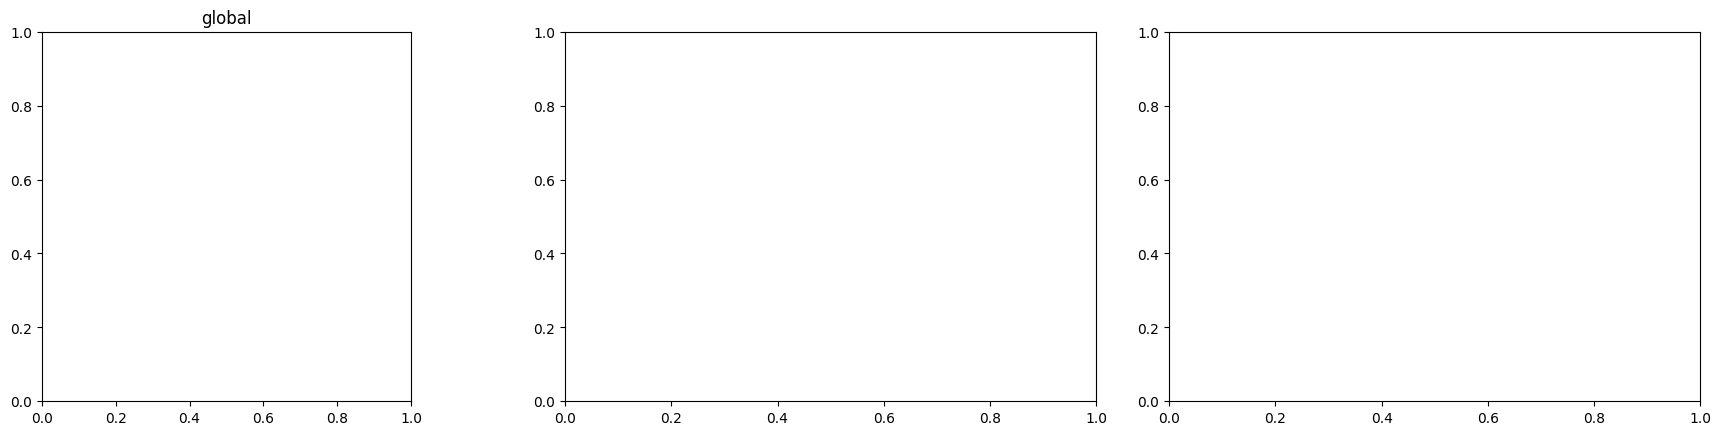

In [ ]:
# read csv data
proportions = pd.read_csv("ex_vivo_proportions_rctd_liver_mouseVisium_JB01.csv",delimiter = '\t')
columns_to_select = ["CentralVeinEndothelialcells", "Mesothelialcells", "PortalVeinEndothelialcells"]
prop = proportions[columns_to_select]

# add column based on the spatial zonation
proportions["spatial_zonation"] = prop.idxmax(axis=1)

print('len(proportions["spatial_zonation"]):',len(proportions["spatial_zonation"]))
print('len(visium.table.obs):',len(visium.table.obs))
print('len(visium.shapes[GSM5764414_JBO001]):',len(visium.shapes['GSM5764414_JBO001']))

#TO DO: only keep spots that are in Annotated_spots
#Annotated_spots = annot['cell'].astype(str)
#visium.table.obs['cell'] = visium.table.obs.index


#print(visium.table.obs[visium.table.obs['cell'].isin(Annotated_spots)])

#print(visium.table.obs['cell'])
#print(Annotated_spots)
#visium.table.obs["spatial_zonation"] = proportions["spatial_zonation"]

#visium.shapes['GSM5764414_JBO001']['spatial_zonation'] = 

visium.pl.render_images(elements="GSM5764414_JBO001_hires_image").pl.render_shapes(elements="GSM5764414_JBO001", color="spatial_zonation").pl.show()


### Cluster marker genes

In [15]:
print(adata.obs.head())
import scanpy as sc

# PCA, Neighbors
sc.pp.pca(adata)
sc.pp.neighbors(adata)

# Leiden
sc.tl.leiden(adata, key_added="clusters")
print(adata.obs.head())
print(adata.obs["clusters"].unique())


                    in_tissue  array_row  array_col  spot_id  \
AAACAAGTATCTCCCA-1          1         50        102        0   
AAACACCAATAACTGC-1          1         59         19        1   
AAACATTTCCCGGATT-1          1         61         97        2   
AAACCCGAACGAAATC-1          1         45        115        3   
AAACCGGGTAGGTACC-1          1         42         28        4   

                               region  total_counts  n_genes_by_counts  \
AAACAAGTATCTCCCA-1  GSM5764414_JBO001       37642.0               4959   
AAACACCAATAACTGC-1  GSM5764414_JBO001       32229.0               4725   
AAACATTTCCCGGATT-1  GSM5764414_JBO001       35277.0               4797   
AAACCCGAACGAAATC-1  GSM5764414_JBO001       34632.0               4785   
AAACCGGGTAGGTACC-1  GSM5764414_JBO001       46259.0               5326   

                              spot_ind  n_counts  mito_percentage clusters  
AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1   37642.0         1.208756        0  
AAACACCAATAACTGC

/tmp/ipykernel_20856/1879351218.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="clusters")


                    in_tissue  array_row  array_col  spot_id  \
AAACAAGTATCTCCCA-1          1         50        102        0   
AAACACCAATAACTGC-1          1         59         19        1   
AAACATTTCCCGGATT-1          1         61         97        2   
AAACCCGAACGAAATC-1          1         45        115        3   
AAACCGGGTAGGTACC-1          1         42         28        4   

                               region  total_counts  n_genes_by_counts  \
AAACAAGTATCTCCCA-1  GSM5764414_JBO001       37642.0               4959   
AAACACCAATAACTGC-1  GSM5764414_JBO001       32229.0               4725   
AAACATTTCCCGGATT-1  GSM5764414_JBO001       35277.0               4797   
AAACCCGAACGAAATC-1  GSM5764414_JBO001       34632.0               4785   
AAACCGGGTAGGTACC-1  GSM5764414_JBO001       46259.0               5326   

                              spot_ind  n_counts  mito_percentage clusters  
AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1   37642.0         1.208756        5  
AAACACCAATAACTGC

categories: 0, 1, 2, etc.
var_group_labels: 3


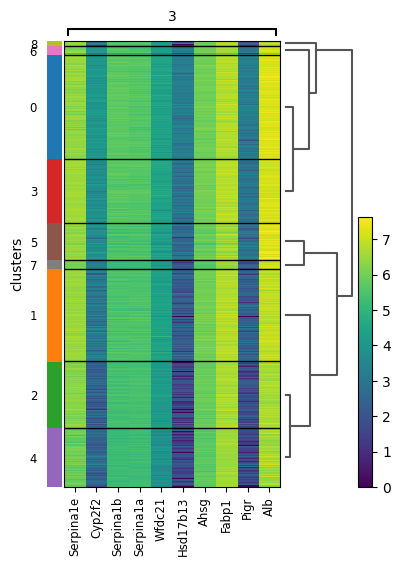

In [16]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="3", n_genes=10, groupby="clusters")